# 1. Developing a model
Data source: https://www.kaggle.com/datasnaek/league-of-legends.

In [113]:
import pandas as pd
import matplotlib.pyplot as pl
import seaborn as sns
import numpy as np
import warnings
warnings.filterwarnings('ignore')
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import classification_report
from sklearn.model_selection import cross_val_score

games_raw = pd.read_csv('C:/Users/xsoni/Desktop/league_of_legends_ranked_games/games.csv')
#games_raw = pd.read_csv('//fspa.myntet.se/userdata/SE-Users2/p901uwv/My Documents/games.csv')

### Selecting data that we want to use

In [114]:
games_raw.head(10)
#games_raw.info() # no null-values, all variables are int64

#games_raw.duplicated().any(axis=0)   # duplicate rows exist in df

#ids = games['gameId']   # run to view duplicates
#games[ids.isin(ids[ids.duplicated()])].sort_values('gameId')

# drop duplicate values
games_temp = games_raw.drop_duplicates()

#games_temp.groupby(['seasonId'])['seasonId'].count() # seasonId same for all games

# probably not much predictive power in adding the below data here for a _SIMPLE_ model, 
#pd.read_json('C:/Users/xsoni/Desktop/league_of_legends_ranked_games/champion_info.json')
#pd.read_json('C:/Users/xsoni/Desktop/league_of_legends_ranked_games/champion_info_2.json')
#pd.read_json('C:/Users/xsoni/Desktop/league_of_legends_ranked_games/summoner_spell_info.json')

# we keep only the variables that we want to keep for our model
games = games_temp[['winner', 'firstBlood', 'firstTower', 'firstInhibitor', 'firstBaron' ,'firstDragon', 'firstRiftHerald'
                   ,'t1_towerKills', 't1_inhibitorKills', 't1_baronKills', 't1_dragonKills', 't1_riftHeraldKills'
                   ,'t2_towerKills', 't2_inhibitorKills', 't2_baronKills', 't2_dragonKills', 't2_riftHeraldKills']]
games

,winner,firstBlood,firstTower,firstInhibitor,firstBaron,firstDragon,firstRiftHerald,t1_towerKills,t1_inhibitorKills,t1_baronKills,t1_dragonKills,t1_riftHeraldKills,t2_towerKills,t2_inhibitorKills,t2_baronKills,t2_dragonKills,t2_riftHeraldKills
0,1,2,1,1,1,1,2,11,1,2,3,0,5,0,0,1,1
1,1,1,1,1,0,1,1,10,4,0,2,1,2,0,0,0,0
2,1,2,1,1,1,2,0,8,1,1,1,0,2,0,0,1,0
3,1,1,1,1,1,1,0,9,2,1,2,0,0,0,0,0,0
4,1,2,1,1,1,1,0,9,2,1,3,0,3,0,0,1,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
51485,2,1,2,2,0,2,0,2,0,0,0,0,10,2,0,4,0
51486,2,1,1,2,2,2,2,5,4,0,2,0,11,7,4,4,1
51487,2,2,2,2,0,1,0,0,0,0,1,0,10,2,0,2,0
51488,2,2,2,2,0,2,0,0,0,0,0,0,11,3,0,1,0


### Notes on dropped variables:
- gameId: no predictive power
- creationTime: no predictive power unless our model takes chronological order into account (ex skill development)
- seasonId: all games are from the same season
- selection of champions and bans: there is likely signal in the choice of champions. 
- gameDuration: can probably be very useful for more complex modeling and synergies with other variables (ex: team setup, if a team does not end "early" against 5 carrys then they usually end up losing).

# Model building
## (a) Logistic regression

### Before feature engineering

In [115]:
X = games.drop(['winner'
               ], axis='columns')
Y = games['winner']
X_train, X_test, Y_train, Y_test = train_test_split(X, Y, test_size=0.2, shuffle=True, random_state=2)

# initiate logistic regression model
log_reg = LogisticRegression(fit_intercept=False)

# cross-validation
games_scores = cross_val_score(log_reg, X_train, Y_train, cv=10)
print('cross-validation accuracy', scores)

print('min acc: ',games_scores.min(),
      '\nmean acc: ',games_scores.mean(),
      '\nmax acc: ',games_scores.max(),
      '\nrange: ',games_scores.max()-scores.min())

cross-validation accuracy 0    0.959119
1    0.964749
2    0.965720
3    0.971841
4    0.966210
5    0.956170
6    0.967434
7    0.963516
8    0.965720
9    0.963271
dtype: float64
min acc:  0.9576395690499511 
mean acc:  0.9615592088779449 
max acc:  0.9669441723800196 
range:  0.010773751224289918


### Feature engineering (*IN PROGRESS)
- win_cond: A team can't win unless the opposite team surrenders early or they have killed at least 5 towers (3 on lane and 2 defending the nexus) and at least 1 inhibitor, hence we can make a variable that's 1 for killing at least 5 towers and 1 inhibitor and 0 else.

In [116]:
games_eng = games

def t1_win_cond(row):
    if row['t1_towerKills'] > 5 and row['t1_inhibitorKills'] > 0:
        return 1
    else:
        return 0
    
def t2_win_cond(row):
    if row['t2_towerKills'] > 5 and row['t2_inhibitorKills'] > 0:
        return 1
    else:
        return 0
    
games_eng['t1_win_cond'] = games_eng.apply(lambda row: t1_win_cond(row), axis=1)
games_eng['t2_win_cond'] = games_eng.apply(lambda row: t2_win_cond(row), axis=1)

We look at correlations:

Correlations against the winner variable: 
 t1_towerKills        -0.771571
t1_win_cond          -0.770406
t1_inhibitorKills    -0.649636
t1_dragonKills       -0.472635
t1_baronKills        -0.369883
t1_riftHeraldKills   -0.218057
firstRiftHerald       0.119891
firstBlood            0.175564
t2_riftHeraldKills    0.226131
firstBaron            0.261336
firstDragon           0.310220
firstTower            0.376347
t2_baronKills         0.398692
t2_dragonKills        0.497055
firstInhibitor        0.536404
t2_inhibitorKills     0.660696
t2_win_cond           0.783994
t2_towerKills         0.785722
winner                1.000000
Name: winner, dtype: float64


<AxesSubplot: >

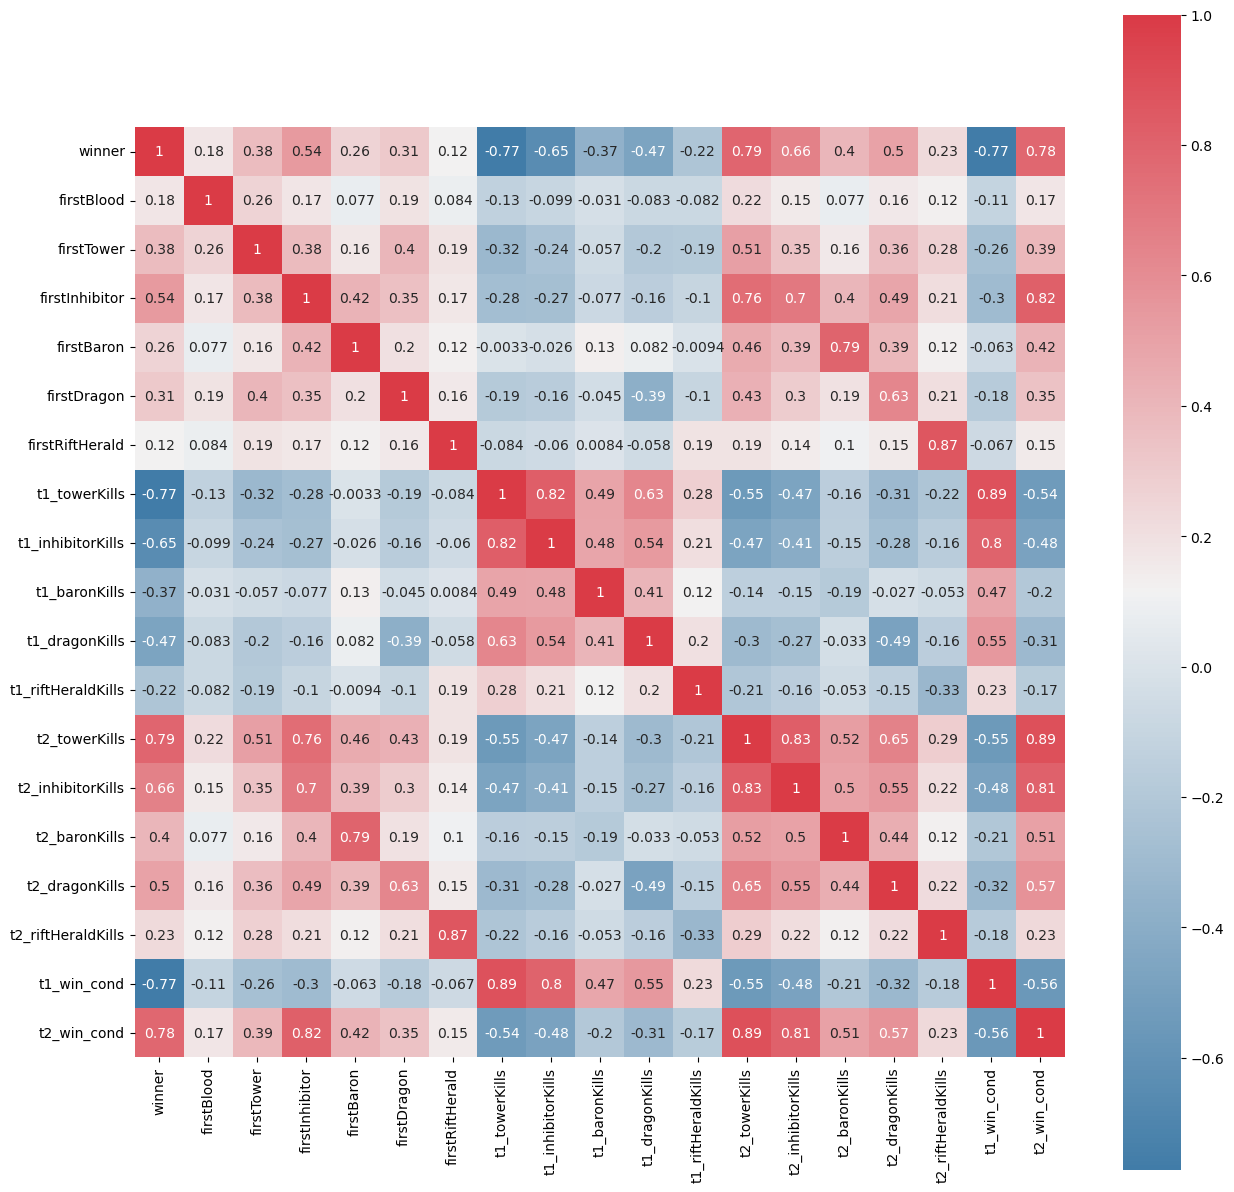

In [117]:
f, ax = pl.subplots(figsize=(15, 15))
print('Correlations against the winner variable: \n' , games.corr()['winner'].sort_values())
corr = games_eng.corr()
sns.heatmap(corr, mask=np.zeros_like(corr, dtype=np.bool), cmap=sns.diverging_palette(240,10,as_cmap=True), square=True, annot=True, ax=ax)

In [120]:
X = games_eng.drop(['winner'
               
                   ], axis='columns')
Y = games_eng['winner']
X_train, X_test, Y_train, Y_test = train_test_split(X, Y, test_size=0.2, shuffle=True, random_state=2)

# initiate logistic regression model
log_reg = LogisticRegression(fit_intercept=False)

# cross-validation
games_eng_scores = cross_val_score(log_reg, X_train, Y_train, cv=10)
print('cross-validation accuracy', games_eng_scores)

print('min acc: ',games_eng_scores.min(),
      '\nmean acc: ',games_eng_scores.mean(),
      '\nmax acc: ',games_eng_scores.max(),
      '\nrange: ',games_eng_scores.max()-scores.min())

cross-validation accuracy [0.96597307 0.96083231 0.96449559 0.95886386 0.96400588 0.96669931
 0.96767875 0.96180215 0.96253673 0.96718903]
min acc:  0.9588638589618022 
mean acc:  0.9640076688201381 
max acc:  0.9676787463271302 
range:  0.011508325171400546


### Regression model comparisons

In [119]:
print('mean acc pre-eng: ', games_scores.mean()
      ,'\nmean acc post-eng: ', games_eng_scores.mean()
        )

mean acc pre-eng:  0.9615592088779449 
mean acc post-eng:  0.9640076688201381


useful links with examples:
- https://machinelearningmastery.com/training-validation-test-split-and-cross-validation-done-right/
- https://machinelearningmastery.com/k-fold-cross-validation/
- https://medium.com/@lily_su/logistic-regression-accuracy-cross-validation-58d9eb58d6e6

### Random Forest

In [ ]:
from sklearn.tree import DecisionTreeClassifier
from sklearn.model_selection import GridSearchCV

criterion=["gini","entropy"]
max_depth=range(4,12,1)
splitter=["best","random"]
dt=DecisionTreeClassifier()
grid_decision_tree=GridSearchCV(estimator=dt,cv=10,param_grid=dict(criterion=criterion,max_depth=max_depth,splitter=splitter))

grid_decision_tree.fit(X_train,Y_train)
print("best score: ", grid_decision_tree.best_score_)
print("best param: ", grid_decision_tree.best_params_)

In [ ]:
dt2=DecisionTreeClassifier(criterion='entropy',max_depth=8, splitter='best')
dt2.fit(X_train,Y_train)
print("score:", dt2.score(X_test,Y_test))

In [ ]:
from sklearn.metrics import confusion_matrix,classification_report
predicted_values = dt2.predict(X_test)
cm=confusion_matrix(Y_test,predicted_values)
cr=classification_report(Y_test,predicted_values)
print('Classification report : \n',cr)

In [ ]:
c=dt2.predict_proba(X_test)
c

## Testing the final model
Re-train model that should be tested on all of the training data and then test it on the held-out test data y_test

# 2. Discussion


From a classification standpoint we (often) assume a decision-rule “if 𝑝 > 0.5 classify as A otherwise B”. Such a decision rule may be good for classification but in the context of odds we are more interested in the uncertainty of the prediction 𝑝 and if the prediction is close to the true quantity 𝑝. Discuss if your model would be applicable in this setting. Would you evaluate your model differently if your aim is to compare the prediction 𝑝 and the true ? Can you perform such a comparison? Obs. 𝑝 this question is essentially open-ended and will be discussed further in person!

- true quantity $\hat{p}$ can not be known, hence we can not know if our prediction is close to the true quantity in terms of a distance between $d(\hat{p},p)$
- we can however evaluate how well the model predicts the winner (we actually have data on that!)
- any smart work arounds? what is even meant by true p? a true underlying probability that a team will win... such can not be known, only modeled

# 3. Given more time I would expand the project by looking into:
- Champion type setup for both teams and length of game:
In my experience playing hon and dota, sometimes one team has problems ending the game and as time progresses the team that was losing turns the game around because they are 3-5 carrys that are getting well-equipped.
- Different model for predicting outcome given early surrender?